In [1]:
trial_number_ml = "010"
random_state_init = 1001

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 18:36:50,356] A new study created in memory with name: no-name-96cf47af-5685-4939-8aaf-623057bf80df


[I 2024-05-01 18:38:47,872] Trial 2 finished with value: 0.6247930190270117 and parameters: {'n_estimators': 558, 'max_depth': 87, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.6247930190270117.


[I 2024-05-01 18:39:09,599] Trial 3 finished with value: 0.6270187628886925 and parameters: {'n_estimators': 724, 'max_depth': 94, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.6270187628886925.


[I 2024-05-01 18:39:27,598] Trial 0 finished with value: 0.6254294537734028 and parameters: {'n_estimators': 609, 'max_depth': 98, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6270187628886925.


[I 2024-05-01 18:40:25,226] Trial 1 finished with value: 0.6279690976137506 and parameters: {'n_estimators': 958, 'max_depth': 78, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:40:40,610] Trial 6 finished with value: 0.6238310019402878 and parameters: {'n_estimators': 399, 'max_depth': 61, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:40:58,066] Trial 8 pruned. 


[I 2024-05-01 18:41:03,825] Trial 4 finished with value: 0.621918650128506 and parameters: {'n_estimators': 868, 'max_depth': 47, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:41:20,671] Trial 10 pruned. 


[I 2024-05-01 18:41:35,664] Trial 5 finished with value: 0.623511006816404 and parameters: {'n_estimators': 818, 'max_depth': 34, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:41:51,792] Trial 11 pruned. 


[I 2024-05-01 18:42:00,307] Trial 12 pruned. 


[I 2024-05-01 18:42:31,281] Trial 14 pruned. 


[I 2024-05-01 18:42:35,618] Trial 15 pruned. 


[I 2024-05-01 18:42:37,896] Trial 9 finished with value: 0.6228730482837086 and parameters: {'n_estimators': 679, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:42:45,019] Trial 7 finished with value: 0.6200037586728837 and parameters: {'n_estimators': 902, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:44:03,421] Trial 13 finished with value: 0.6203232458679995 and parameters: {'n_estimators': 990, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:44:16,028] Trial 19 pruned. 


[I 2024-05-01 18:44:36,970] Trial 20 pruned. 


[I 2024-05-01 18:44:58,839] Trial 17 finished with value: 0.6225525452310567 and parameters: {'n_estimators': 971, 'max_depth': 73, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:44:59,671] Trial 16 finished with value: 0.6222340738934772 and parameters: {'n_estimators': 987, 'max_depth': 73, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:45:10,584] Trial 18 finished with value: 0.6241469336340272 and parameters: {'n_estimators': 976, 'max_depth': 71, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:45:12,363] Trial 22 pruned. 


[I 2024-05-01 18:45:15,769] Trial 23 pruned. 


[I 2024-05-01 18:45:25,721] Trial 21 pruned. 


[I 2024-05-01 18:45:48,103] Trial 24 pruned. 


[I 2024-05-01 18:45:49,832] Trial 25 pruned. 


[I 2024-05-01 18:45:56,683] Trial 26 pruned. 


[I 2024-05-01 18:46:06,215] Trial 27 pruned. 


[I 2024-05-01 18:46:25,114] Trial 28 pruned. 


[I 2024-05-01 18:46:29,183] Trial 29 pruned. 


[I 2024-05-01 18:46:34,368] Trial 30 pruned. 


[I 2024-05-01 18:46:39,964] Trial 31 pruned. 


[I 2024-05-01 18:46:42,806] Trial 33 pruned. 


[I 2024-05-01 18:46:44,005] Trial 32 pruned. 


[I 2024-05-01 18:46:47,901] Trial 34 pruned. 


[I 2024-05-01 18:46:51,859] Trial 35 pruned. 


[I 2024-05-01 18:46:54,904] Trial 36 pruned. 


[I 2024-05-01 18:46:56,594] Trial 37 pruned. 


[I 2024-05-01 18:47:06,722] Trial 41 pruned. 


[I 2024-05-01 18:47:14,249] Trial 40 pruned. 


[I 2024-05-01 18:47:31,846] Trial 42 pruned. 


[I 2024-05-01 18:47:37,368] Trial 43 pruned. 


[I 2024-05-01 18:47:38,938] Trial 39 finished with value: 0.622554069017361 and parameters: {'n_estimators': 405, 'max_depth': 66, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:47:48,204] Trial 45 pruned. 


[I 2024-05-01 18:48:34,835] Trial 38 finished with value: 0.6241509970641719 and parameters: {'n_estimators': 825, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:49:48,088] Trial 44 finished with value: 0.6235089751013317 and parameters: {'n_estimators': 932, 'max_depth': 35, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:49:57,692] Trial 46 finished with value: 0.6263787726409248 and parameters: {'n_estimators': 931, 'max_depth': 87, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:50:07,615] Trial 47 finished with value: 0.6225566086612013 and parameters: {'n_estimators': 937, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279690976137506.


[I 2024-05-01 18:50:30,266] Trial 48 finished with value: 0.6282901085951706 and parameters: {'n_estimators': 917, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 48 with value: 0.6282901085951706.


[I 2024-05-01 18:50:40,331] Trial 49 finished with value: 0.6260608092321134 and parameters: {'n_estimators': 907, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 48 with value: 0.6282901085951706.


Best trial for RandomForestClassifier:
  Value: 0.6282901085951706
  Params: 
    n_estimators: 917
    max_depth: 38
    min_samples_split: 4
    min_samples_leaf: 6
    max_features: log2

Best hyperparameters for RandomForestClassifier: {'n_estimators': 917, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2'}


[I 2024-05-01 18:50:47,700] A new study created in memory with name: no-name-eef0cb35-72fe-4858-876d-c8298467629c


RandomForestClassifier accuracy: 0.6115



[I 2024-05-01 18:50:54,590] Trial 1 finished with value: 0.6047130710389175 and parameters: {'n_estimators': 126, 'max_depth': 10, 'learning_rate': 0.17597974632867022, 'min_child_weight': 3, 'subsample': 0.8219538498110123, 'colsample_bytree': 0.9567070675546858, 'gamma': 4.574543111122999, 'reg_lambda': 8.390018236090082, 'reg_alpha': 1.2478940950880562}. Best is trial 1 with value: 0.6047130710389175.


[I 2024-05-01 18:50:55,463] Trial 2 finished with value: 0.6018458131431649 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.2923599963988349, 'min_child_weight': 4, 'subsample': 0.8457132032420351, 'colsample_bytree': 0.8679211840015599, 'gamma': 2.0344625467961768, 'reg_lambda': 2.5600451179129373, 'reg_alpha': 0.6313528442885799}. Best is trial 1 with value: 0.6047130710389175.


[I 2024-05-01 18:50:59,482] Trial 0 finished with value: 0.6015232783754406 and parameters: {'n_estimators': 199, 'max_depth': 9, 'learning_rate': 0.2687946325426439, 'min_child_weight': 8, 'subsample': 0.8576111765431668, 'colsample_bytree': 0.5207414309973735, 'gamma': 1.7235656779768616, 'reg_lambda': 0.30441145218936133, 'reg_alpha': 1.1241159088868653}. Best is trial 1 with value: 0.6047130710389175.


[I 2024-05-01 18:51:08,166] Trial 3 finished with value: 0.598021109519601 and parameters: {'n_estimators': 323, 'max_depth': 6, 'learning_rate': 0.2043520788192327, 'min_child_weight': 8, 'subsample': 0.9568536294862593, 'colsample_bytree': 0.9313344942887571, 'gamma': 0.34101475936823444, 'reg_lambda': 1.4231853571346202, 'reg_alpha': 0.3826527920441224}. Best is trial 1 with value: 0.6047130710389175.


[I 2024-05-01 18:51:10,178] Trial 5 finished with value: 0.6066264387082356 and parameters: {'n_estimators': 199, 'max_depth': 8, 'learning_rate': 0.059549376944022896, 'min_child_weight': 2, 'subsample': 0.8498678327720263, 'colsample_bytree': 0.7372342249006916, 'gamma': 3.0300697842601694, 'reg_lambda': 0.36531347520771645, 'reg_alpha': 0.011565100640548923}. Best is trial 5 with value: 0.6066264387082356.


[I 2024-05-01 18:51:24,957] Trial 4 finished with value: 0.6139533111876391 and parameters: {'n_estimators': 556, 'max_depth': 5, 'learning_rate': 0.023767731932628614, 'min_child_weight': 7, 'subsample': 0.7593970600048963, 'colsample_bytree': 0.6348734253105865, 'gamma': 2.8332745484456714, 'reg_lambda': 0.9039329427688487, 'reg_alpha': 0.016419619593982537}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:26,257] Trial 6 finished with value: 0.6047145948252217 and parameters: {'n_estimators': 734, 'max_depth': 5, 'learning_rate': 0.2328735218210253, 'min_child_weight': 7, 'subsample': 0.6079583331526761, 'colsample_bytree': 0.5765654065838252, 'gamma': 3.3234719745101526, 'reg_lambda': 2.107319761379779, 'reg_alpha': 5.094593087030702}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:28,469] Trial 8 finished with value: 0.6107614868090898 and parameters: {'n_estimators': 406, 'max_depth': 10, 'learning_rate': 0.09706954236422023, 'min_child_weight': 3, 'subsample': 0.8084706887469836, 'colsample_bytree': 0.8278393745865247, 'gamma': 1.1435988922587337, 'reg_lambda': 1.5806902918823826, 'reg_alpha': 6.499262770893085}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:28,495] Trial 7 finished with value: 0.5964307845467752 and parameters: {'n_estimators': 188, 'max_depth': 10, 'learning_rate': 0.22871772592860032, 'min_child_weight': 10, 'subsample': 0.6739287216493288, 'colsample_bytree': 0.790051915116954, 'gamma': 0.4803169083754555, 'reg_lambda': 4.666244694398089, 'reg_alpha': 0.06669772933355496}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:30,107] Trial 11 pruned. 


[I 2024-05-01 18:51:36,971] Trial 12 finished with value: 0.6072618575970905 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.1741147298392247, 'min_child_weight': 1, 'subsample': 0.8803059668944722, 'colsample_bytree': 0.6904279819437896, 'gamma': 1.7788341682273279, 'reg_lambda': 3.383803134409104, 'reg_alpha': 0.39295906183471646}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:41,598] Trial 10 finished with value: 0.60407308079115 and parameters: {'n_estimators': 337, 'max_depth': 8, 'learning_rate': 0.14586098244977863, 'min_child_weight': 9, 'subsample': 0.7022200776273106, 'colsample_bytree': 0.9784430246718767, 'gamma': 4.869889121837274, 'reg_lambda': 0.42599778256400506, 'reg_alpha': 0.20921311508454965}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:43,551] Trial 13 pruned. 


[I 2024-05-01 18:51:43,677] Trial 14 pruned. 


[I 2024-05-01 18:51:47,656] Trial 9 finished with value: 0.6005648167900933 and parameters: {'n_estimators': 593, 'max_depth': 9, 'learning_rate': 0.11737202932788987, 'min_child_weight': 8, 'subsample': 0.9780914593142139, 'colsample_bytree': 0.8687226007238172, 'gamma': 4.317508773558089, 'reg_lambda': 0.20080158272944665, 'reg_alpha': 0.26536218136366885}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:51:56,150] Trial 16 pruned. 


[I 2024-05-01 18:52:09,879] Trial 15 finished with value: 0.5983324698544277 and parameters: {'n_estimators': 584, 'max_depth': 3, 'learning_rate': 0.09519396595002905, 'min_child_weight': 5, 'subsample': 0.5062901027099524, 'colsample_bytree': 0.6174545188109395, 'gamma': 1.2516285740401492, 'reg_lambda': 0.01968019798378227, 'reg_alpha': 0.023777052839826077}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:52:13,294] Trial 17 finished with value: 0.612675362407176 and parameters: {'n_estimators': 483, 'max_depth': 6, 'learning_rate': 0.013250877680419104, 'min_child_weight': 5, 'subsample': 0.7838747459387143, 'colsample_bytree': 0.8331402192105267, 'gamma': 1.2604598998434462, 'reg_lambda': 0.09911445735634519, 'reg_alpha': 0.010007804556698197}. Best is trial 4 with value: 0.6139533111876391.


[I 2024-05-01 18:52:15,231] Trial 18 finished with value: 0.6168195532258556 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.020278231273753916, 'min_child_weight': 4, 'subsample': 0.7688573747341408, 'colsample_bytree': 0.7985287941229644, 'gamma': 2.4871169748415194, 'reg_lambda': 0.06581703680138663, 'reg_alpha': 0.013552446447508656}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:20,659] Trial 19 finished with value: 0.606301364296671 and parameters: {'n_estimators': 424, 'max_depth': 5, 'learning_rate': 0.015401640783256395, 'min_child_weight': 3, 'subsample': 0.7824576223364933, 'colsample_bytree': 0.7674977664768057, 'gamma': 2.5079982688281603, 'reg_lambda': 0.08509611263123075, 'reg_alpha': 5.291612253036351}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:21,316] Trial 22 pruned. 


[I 2024-05-01 18:52:25,812] Trial 20 finished with value: 0.6066198356342507 and parameters: {'n_estimators': 433, 'max_depth': 5, 'learning_rate': 0.01899725113021214, 'min_child_weight': 3, 'subsample': 0.7818313091595449, 'colsample_bytree': 0.7825607519399703, 'gamma': 2.470359516866253, 'reg_lambda': 0.08118416860332675, 'reg_alpha': 6.030075257677734}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:28,581] Trial 21 finished with value: 0.6152271965379577 and parameters: {'n_estimators': 419, 'max_depth': 5, 'learning_rate': 0.014090494250881165, 'min_child_weight': 6, 'subsample': 0.6275458506252714, 'colsample_bytree': 0.5018221377362986, 'gamma': 2.450825952177292, 'reg_lambda': 0.0686950904310949, 'reg_alpha': 0.03338760285590007}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:29,543] Trial 23 finished with value: 0.6117235038958136 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.05481923958319338, 'min_child_weight': 7, 'subsample': 0.6544152324526613, 'colsample_bytree': 0.6689705204152657, 'gamma': 3.5565255265929934, 'reg_lambda': 0.0382328247353099, 'reg_alpha': 0.028965467630060835}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:30,611] Trial 26 pruned. 


[I 2024-05-01 18:52:33,308] Trial 28 pruned. 


[I 2024-05-01 18:52:34,088] Trial 25 finished with value: 0.6161902294822174 and parameters: {'n_estimators': 263, 'max_depth': 7, 'learning_rate': 0.06393593861455017, 'min_child_weight': 6, 'subsample': 0.6181207069648079, 'colsample_bytree': 0.8924609913044212, 'gamma': 3.672685256854993, 'reg_lambda': 0.041098780393594936, 'reg_alpha': 0.024438296599662915}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:35,186] Trial 24 finished with value: 0.6133138288686395 and parameters: {'n_estimators': 458, 'max_depth': 7, 'learning_rate': 0.01005566647826669, 'min_child_weight': 6, 'subsample': 0.7409925409758767, 'colsample_bytree': 0.9079577050948161, 'gamma': 3.5434028744239017, 'reg_lambda': 0.04547655840149825, 'reg_alpha': 0.02957562285765988}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:36,152] Trial 27 finished with value: 0.6101250520626987 and parameters: {'n_estimators': 266, 'max_depth': 7, 'learning_rate': 0.06434667980409484, 'min_child_weight': 6, 'subsample': 0.6257506942928527, 'colsample_bytree': 0.5228910980630663, 'gamma': 3.832406901762251, 'reg_lambda': 0.03357946547585302, 'reg_alpha': 0.13012598622096175}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:41,992] Trial 31 finished with value: 0.611404524629466 and parameters: {'n_estimators': 246, 'max_depth': 8, 'learning_rate': 0.03722120401108826, 'min_child_weight': 4, 'subsample': 0.586222232087883, 'colsample_bytree': 0.7329378625214668, 'gamma': 4.032310772744612, 'reg_lambda': 0.02092606016679713, 'reg_alpha': 0.04622357320988672}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:42,209] Trial 30 finished with value: 0.613317892298784 and parameters: {'n_estimators': 270, 'max_depth': 7, 'learning_rate': 0.042470597578561545, 'min_child_weight': 4, 'subsample': 0.582728586513631, 'colsample_bytree': 0.9145702471188589, 'gamma': 3.90216978327021, 'reg_lambda': 0.04111583667054118, 'reg_alpha': 0.04494206276044512}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:42,367] Trial 32 finished with value: 0.6085321874460325 and parameters: {'n_estimators': 220, 'max_depth': 8, 'learning_rate': 0.03814167908172062, 'min_child_weight': 4, 'subsample': 0.5457961816412512, 'colsample_bytree': 0.7374952008153993, 'gamma': 4.117552059668278, 'reg_lambda': 0.011219276318823551, 'reg_alpha': 0.044653140337874}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:42,942] Trial 29 finished with value: 0.6165071770334929 and parameters: {'n_estimators': 371, 'max_depth': 7, 'learning_rate': 0.03743873424974073, 'min_child_weight': 6, 'subsample': 0.5734457961777081, 'colsample_bytree': 0.7282416242726326, 'gamma': 2.743335410414591, 'reg_lambda': 0.1768839066297545, 'reg_alpha': 0.018388140413741753}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:43,881] Trial 33 pruned. 


[I 2024-05-01 18:52:44,155] Trial 35 pruned. 


[I 2024-05-01 18:52:44,884] Trial 36 pruned. 


[I 2024-05-01 18:52:45,384] Trial 37 pruned. 


[I 2024-05-01 18:52:46,787] Trial 39 pruned. 


[I 2024-05-01 18:52:49,020] Trial 41 pruned. 


[I 2024-05-01 18:52:50,566] Trial 34 finished with value: 0.6123563831408283 and parameters: {'n_estimators': 332, 'max_depth': 6, 'learning_rate': 0.033706513250376956, 'min_child_weight': 7, 'subsample': 0.5452728677009886, 'colsample_bytree': 0.5625499673354846, 'gamma': 2.8206303436126294, 'reg_lambda': 0.22175203546648248, 'reg_alpha': 0.017600263843042266}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:51,625] Trial 42 pruned. 


[I 2024-05-01 18:52:51,765] Trial 38 finished with value: 0.6123604465709729 and parameters: {'n_estimators': 305, 'max_depth': 6, 'learning_rate': 0.028609258390387936, 'min_child_weight': 6, 'subsample': 0.6226443307748242, 'colsample_bytree': 0.998278744251887, 'gamma': 1.7270326416058133, 'reg_lambda': 0.2960664501168861, 'reg_alpha': 0.1008044795937854}. Best is trial 18 with value: 0.6168195532258556.


[I 2024-05-01 18:52:53,163] Trial 43 pruned. 


[I 2024-05-01 18:52:54,857] Trial 40 finished with value: 0.616823108727232 and parameters: {'n_estimators': 312, 'max_depth': 9, 'learning_rate': 0.029801386128873997, 'min_child_weight': 5, 'subsample': 0.6143377960328036, 'colsample_bytree': 0.9970533642024928, 'gamma': 3.017969418898327, 'reg_lambda': 0.5179261354179059, 'reg_alpha': 0.9871922300560211}. Best is trial 40 with value: 0.616823108727232.


[I 2024-05-01 18:52:55,893] Trial 44 pruned. 


[I 2024-05-01 18:52:56,814] Trial 46 pruned. 


[I 2024-05-01 18:52:58,536] Trial 49 pruned. 


[I 2024-05-01 18:52:59,049] Trial 48 pruned. 


[I 2024-05-01 18:53:01,305] Trial 45 finished with value: 0.6174625910462317 and parameters: {'n_estimators': 486, 'max_depth': 4, 'learning_rate': 0.023596256249697203, 'min_child_weight': 7, 'subsample': 0.8157783950537524, 'colsample_bytree': 0.7028982643017093, 'gamma': 3.0929640467682584, 'reg_lambda': 0.47077310129035344, 'reg_alpha': 0.012669128690633379}. Best is trial 45 with value: 0.6174625910462317.


[I 2024-05-01 18:53:06,563] Trial 47 finished with value: 0.614274322169059 and parameters: {'n_estimators': 492, 'max_depth': 10, 'learning_rate': 0.024243182786782, 'min_child_weight': 4, 'subsample': 0.5989368951800565, 'colsample_bytree': 0.9457984543190063, 'gamma': 2.392739920706662, 'reg_lambda': 0.5992799106803425, 'reg_alpha': 1.913219255537369}. Best is trial 45 with value: 0.6174625910462317.


Best trial for XGBClassifier:
  Value: 0.6174625910462317
  Params: 
    n_estimators: 486
    max_depth: 4
    learning_rate: 0.023596256249697203
    min_child_weight: 7
    subsample: 0.8157783950537524
    colsample_bytree: 0.7028982643017093
    gamma: 3.0929640467682584
    reg_lambda: 0.47077310129035344
    reg_alpha: 0.012669128690633379

Best hyperparameters for XGBClassifier: {'n_estimators': 486, 'max_depth': 4, 'learning_rate': 0.023596256249697203, 'min_child_weight': 7, 'subsample': 0.8157783950537524, 'colsample_bytree': 0.7028982643017093, 'gamma': 3.0929640467682584, 'reg_lambda': 0.47077310129035344, 'reg_alpha': 0.012669128690633379}


[I 2024-05-01 18:53:46,021] A new study created in memory with name: no-name-5068f927-91e4-4766-99c2-8d051e373153


XGBClassifier accuracy: 0.5975



[I 2024-05-01 18:53:46,707] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 10, 'learning_rate': 0.32925801555772044, 'n_estimators': 332, 'min_child_weight': 0.07800802514879096, 'min_child_samples': 1515, 'subsample': 0.8299896244427419, 'colsample_bytree': 0.8785827258968477, 'reg_alpha': 0.00032401432087775906, 'reg_lambda': 6.202036981699329e-10}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 18:53:46,769] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 0, 'learning_rate': 0.04382170343809273, 'n_estimators': 696, 'min_child_weight': 0.002830671085763618, 'min_child_samples': 1587, 'subsample': 0.9428998582791981, 'colsample_bytree': 0.9550090067076064, 'reg_alpha': 0.38046117682564395, 'reg_lambda': 3.692866326271322e-10}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 18:53:47,358] Trial 1 finished with value: 0.581125366978535 and parameters: {'boosting_type': 'goss', 'num_leaves': 57, 'max_depth': 6, 'learning_rate': 0.22240157736899352, 'n_estimators': 286, 'min_child_weight': 0.0033855877987640235, 'min_child_samples': 703, 'subsample': 0.8619610985393096, 'colsample_bytree': 0.8918051411948906, 'reg_alpha': 0.09012869852039675, 'reg_lambda': 2.069335747599194e-09}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:47,377] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'max_depth': 0, 'learning_rate': 0.3456006141613517, 'n_estimators': 392, 'min_child_weight': 0.007022124956793233, 'min_child_samples': 1949, 'subsample': 0.9838727566047196, 'colsample_bytree': 0.9465184543354004, 'reg_alpha': 4.915289214178915e-07, 'reg_lambda': 0.00016130885403025638}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:47,494] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 68, 'max_depth': 2, 'learning_rate': 0.23164851638309872, 'n_estimators': 731, 'min_child_weight': 0.011459083896505297, 'min_child_samples': 1370, 'subsample': 0.9472765350145959, 'colsample_bytree': 0.8733002797854553, 'reg_alpha': 3.101359786182309e-06, 'reg_lambda': 0.9046977022878333}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:48,175] Trial 7 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'max_depth': 1, 'learning_rate': 0.2865984198522767, 'n_estimators': 880, 'min_child_weight': 0.006990534607318125, 'min_child_samples': 1763, 'subsample': 0.9982416361311048, 'colsample_bytree': 0.958258653478551, 'reg_alpha': 2.9696677579894357e-06, 'reg_lambda': 3.0129993359012216e-05}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:48,667] Trial 6 finished with value: 0.5747473054378854 and parameters: {'boosting_type': 'goss', 'num_leaves': 48, 'max_depth': 6, 'learning_rate': 0.31672135521421535, 'n_estimators': 259, 'min_child_weight': 0.004073648302112958, 'min_child_samples': 379, 'subsample': 0.8693583739736042, 'colsample_bytree': 0.8576826288510772, 'reg_alpha': 4.236762701031261e-07, 'reg_lambda': 0.001685760421823598}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:48,923] Trial 9 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.3672105771652634, 'n_estimators': 719, 'min_child_weight': 0.060887692179827424, 'min_child_samples': 1324, 'subsample': 0.8807266207986466, 'colsample_bytree': 0.8481998420743107, 'reg_alpha': 0.01625949175076753, 'reg_lambda': 0.00017008427445367775}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:49,552] Trial 11 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 9, 'learning_rate': 0.46990935068699274, 'n_estimators': 452, 'min_child_weight': 0.0625504869177907, 'min_child_samples': 1334, 'subsample': 0.939603114786421, 'colsample_bytree': 0.8387914324219219, 'reg_alpha': 5.148870810936125e-07, 'reg_lambda': 4.668606601770926e-07}. Best is trial 1 with value: 0.581125366978535.


[I 2024-05-01 18:53:49,639] Trial 8 finished with value: 0.58844919188533 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.22489336031037382, 'n_estimators': 340, 'min_child_weight': 0.0012629970239612797, 'min_child_samples': 665, 'subsample': 0.9539465931892991, 'colsample_bytree': 0.9997351085197582, 'reg_alpha': 0.009221840442351272, 'reg_lambda': 6.690614795554049e-07}. Best is trial 8 with value: 0.58844919188533.


[I 2024-05-01 18:53:51,366] Trial 10 finished with value: 0.5779391298164345 and parameters: {'boosting_type': 'goss', 'num_leaves': 84, 'max_depth': 11, 'learning_rate': 0.1568630238246642, 'n_estimators': 825, 'min_child_weight': 0.043546518209163124, 'min_child_samples': 755, 'subsample': 0.9154956731235149, 'colsample_bytree': 0.8093026925448101, 'reg_alpha': 0.4741744840577135, 'reg_lambda': 2.9009539459342753e-08}. Best is trial 8 with value: 0.58844919188533.


[I 2024-05-01 18:53:51,759] Trial 12 finished with value: 0.5811243511209987 and parameters: {'boosting_type': 'goss', 'num_leaves': 87, 'max_depth': 5, 'learning_rate': 0.33525991857947596, 'n_estimators': 493, 'min_child_weight': 0.002075008557403621, 'min_child_samples': 414, 'subsample': 0.9629045355489947, 'colsample_bytree': 0.9255346095020865, 'reg_alpha': 0.0007973781674372593, 'reg_lambda': 0.24177942197789154}. Best is trial 8 with value: 0.58844919188533.


[I 2024-05-01 18:53:52,414] Trial 13 finished with value: 0.597378071699225 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 15, 'learning_rate': 0.11101491679273287, 'n_estimators': 106, 'min_child_weight': 0.001100265415743541, 'min_child_samples': 146, 'subsample': 0.9139909549337087, 'colsample_bytree': 0.9950940920928767, 'reg_alpha': 1.898161661942587e-10, 'reg_lambda': 1.1541837945245749e-07}. Best is trial 13 with value: 0.597378071699225.


[I 2024-05-01 18:53:52,518] Trial 14 finished with value: 0.5932293095216327 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 5, 'learning_rate': 0.15387007619285026, 'n_estimators': 121, 'min_child_weight': 0.0011341215491052533, 'min_child_samples': 720, 'subsample': 0.8031771295424015, 'colsample_bytree': 0.9995002958400454, 'reg_alpha': 0.0008968631550051454, 'reg_lambda': 7.088644939583469e-08}. Best is trial 13 with value: 0.597378071699225.


[I 2024-05-01 18:53:53,002] Trial 15 finished with value: 0.5935538760044291 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 15, 'learning_rate': 0.17051453694598123, 'n_estimators': 176, 'min_child_weight': 0.0011411854178841208, 'min_child_samples': 768, 'subsample': 0.8093779783104726, 'colsample_bytree': 0.9959526339601402, 'reg_alpha': 3.0744079860479764e-10, 'reg_lambda': 4.6307596307745185e-08}. Best is trial 13 with value: 0.597378071699225.


[I 2024-05-01 18:53:56,537] Trial 0 finished with value: 0.589726632737025 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': -1, 'learning_rate': 0.2379041106189041, 'n_estimators': 513, 'min_child_weight': 0.001176866824594057, 'min_child_samples': 731, 'subsample': 0.8184674969535168, 'colsample_bytree': 0.9591748345532346, 'reg_alpha': 0.5419647186771195, 'reg_lambda': 0.00015174773914613946}. Best is trial 13 with value: 0.597378071699225.


[I 2024-05-01 18:53:57,518] Trial 16 finished with value: 0.6012053149666292 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 14, 'learning_rate': 0.07695399230301231, 'n_estimators': 117, 'min_child_weight': 0.001006397047253954, 'min_child_samples': 55, 'subsample': 0.9100184665823782, 'colsample_bytree': 0.9991932679164467, 'reg_alpha': 1.1366482933679883e-10, 'reg_lambda': 4.247605958301028e-07}. Best is trial 16 with value: 0.6012053149666292.


[I 2024-05-01 18:53:58,840] Trial 17 finished with value: 0.6123619703572771 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 14, 'learning_rate': 0.10335938601757921, 'n_estimators': 106, 'min_child_weight': 0.0010561124950977505, 'min_child_samples': 27, 'subsample': 0.8039199429203888, 'colsample_bytree': 0.9987881311619896, 'reg_alpha': 1.1413506479692036e-10, 'reg_lambda': 1.261980117124718e-07}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:53:59,074] Trial 19 pruned. 


[I 2024-05-01 18:54:00,467] Trial 18 finished with value: 0.5986621156249048 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 15, 'learning_rate': 0.003894751128960511, 'n_estimators': 127, 'min_child_weight': 0.02006534944429326, 'min_child_samples': 50, 'subsample': 0.9025946937893286, 'colsample_bytree': 0.980368806205209, 'reg_alpha': 1.3316720626831107e-10, 'reg_lambda': 1.3128836205768788e-08}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:01,414] Trial 22 finished with value: 0.6012007436077165 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 13, 'learning_rate': 0.08170312093410378, 'n_estimators': 203, 'min_child_weight': 0.0018856137224089703, 'min_child_samples': 293, 'subsample': 0.8386181152028788, 'colsample_bytree': 0.9218518164969692, 'reg_alpha': 4.064353577444922e-09, 'reg_lambda': 2.470482990692126e-06}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:02,174] Trial 20 finished with value: 0.5983416125722529 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 15, 'learning_rate': 0.05491003790500534, 'n_estimators': 192, 'min_child_weight': 0.018771035550269464, 'min_child_samples': 117, 'subsample': 0.9105555953952985, 'colsample_bytree': 0.9147769601875806, 'reg_alpha': 2.1919158379237956e-10, 'reg_lambda': 1.3663617694782622e-06}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:03,780] Trial 24 finished with value: 0.5996068631335142 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 12, 'learning_rate': 0.08944299390458918, 'n_estimators': 231, 'min_child_weight': 0.001956302742630582, 'min_child_samples': 303, 'subsample': 0.8456398515722754, 'colsample_bytree': 0.9248481933033277, 'reg_alpha': 6.1034245216722435e-09, 'reg_lambda': 2.8851645342299786e-06}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:04,632] Trial 25 finished with value: 0.6037485143083534 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'max_depth': 12, 'learning_rate': 0.09994860750099785, 'n_estimators': 218, 'min_child_weight': 0.002009800363376902, 'min_child_samples': 326, 'subsample': 0.8417201113653783, 'colsample_bytree': 0.9349009515417074, 'reg_alpha': 6.05178638358185e-09, 'reg_lambda': 4.617337129007519e-06}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:05,192] Trial 27 pruned. 


[I 2024-05-01 18:54:05,696] Trial 28 pruned. 


[I 2024-05-01 18:54:06,246] Trial 23 pruned. 


[I 2024-05-01 18:54:06,356] Trial 26 finished with value: 0.6002382185922247 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'max_depth': 13, 'learning_rate': 0.10566901029040195, 'n_estimators': 214, 'min_child_weight': 0.0019102773941804766, 'min_child_samples': 296, 'subsample': 0.8349269924698962, 'colsample_bytree': 0.9744204948790488, 'reg_alpha': 4.944252613713768e-09, 'reg_lambda': 7.87517316749655e-06}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:06,626] Trial 30 pruned. 


[I 2024-05-01 18:54:06,763] Trial 31 pruned. 


[I 2024-05-01 18:54:08,638] Trial 33 pruned. 


[I 2024-05-01 18:54:09,109] Trial 29 finished with value: 0.6059869563892359 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'max_depth': 13, 'learning_rate': 0.03974912617099406, 'n_estimators': 285, 'min_child_weight': 0.0026333226331268877, 'min_child_samples': 268, 'subsample': 0.8257118371675607, 'colsample_bytree': 0.9057655278477919, 'reg_alpha': 1.3782494989645875e-09, 'reg_lambda': 4.5716953045658426e-09}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:09,351] Trial 32 pruned. 


[I 2024-05-01 18:54:11,732] Trial 34 finished with value: 0.5973801034142971 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 14, 'learning_rate': 0.07186636112787068, 'n_estimators': 172, 'min_child_weight': 0.0014123609295274835, 'min_child_samples': 182, 'subsample': 0.9285460322430908, 'colsample_bytree': 0.9095353452317857, 'reg_alpha': 3.7431780453345166e-08, 'reg_lambda': 5.5325808245370774e-05}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:12,262] Trial 36 finished with value: 0.5951502961224717 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': 14, 'learning_rate': 0.20293253349439264, 'n_estimators': 162, 'min_child_weight': 0.002804099332777314, 'min_child_samples': 194, 'subsample': 0.8627713991562649, 'colsample_bytree': 0.8883863187252404, 'reg_alpha': 9.505163350337821e-10, 'reg_lambda': 4.86090844296392e-09}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:12,282] Trial 35 finished with value: 0.6008802405550646 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 14, 'learning_rate': 0.0689478838120424, 'n_estimators': 173, 'min_child_weight': 0.002779237118421119, 'min_child_samples': 198, 'subsample': 0.820522225704835, 'colsample_bytree': 0.8867063218491401, 'reg_alpha': 3.5227554988434046e-08, 'reg_lambda': 3.3498285468625004e-09}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:12,917] Trial 37 pruned. 


[I 2024-05-01 18:54:22,156] Trial 39 finished with value: 0.6031202064222513 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 12, 'learning_rate': 0.02929917651145826, 'n_estimators': 263, 'min_child_weight': 0.00416705802416674, 'min_child_samples': 44, 'subsample': 0.8892869315349294, 'colsample_bytree': 0.9649093906066785, 'reg_alpha': 8.812375716057214e-10, 'reg_lambda': 1.9316862044955426e-09}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:23,382] Trial 41 pruned. 


[I 2024-05-01 18:54:23,488] Trial 38 finished with value: 0.6037571490974105 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'max_depth': 11, 'learning_rate': 0.02602480985079822, 'n_estimators': 245, 'min_child_weight': 0.0025371762850578314, 'min_child_samples': 31, 'subsample': 0.8864671118246985, 'colsample_bytree': 0.9866555036780177, 'reg_alpha': 1.3387974956466541e-09, 'reg_lambda': 7.872633756809592e-10}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:23,766] Trial 21 finished with value: 0.5894127327583579 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 13, 'learning_rate': 0.025137851410719114, 'n_estimators': 986, 'min_child_weight': 0.02912504991656978, 'min_child_samples': 92, 'subsample': 0.8435691963130343, 'colsample_bytree': 0.9200045367749851, 'reg_alpha': 4.4660315461347275e-09, 'reg_lambda': 3.2502872035395895e-06}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:23,823] Trial 42 pruned. 


[I 2024-05-01 18:54:24,010] Trial 43 pruned. 


[I 2024-05-01 18:54:24,433] Trial 45 pruned. 


[I 2024-05-01 18:54:24,534] Trial 44 pruned. 


[I 2024-05-01 18:54:24,906] Trial 46 pruned. 


[I 2024-05-01 18:54:25,039] Trial 48 pruned. 


[I 2024-05-01 18:54:26,012] Trial 49 pruned. 


[I 2024-05-01 18:54:27,643] Trial 47 finished with value: 0.5929118540415892 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'max_depth': 12, 'learning_rate': 0.252958798226396, 'n_estimators': 251, 'min_child_weight': 0.00849500353334401, 'min_child_samples': 244, 'subsample': 0.8543864739121785, 'colsample_bytree': 0.9842647955990139, 'reg_alpha': 1.4588618341633006e-08, 'reg_lambda': 1.5582444064377769e-09}. Best is trial 17 with value: 0.6123619703572771.


[I 2024-05-01 18:54:28,821] Trial 40 finished with value: 0.6040766362925264 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'max_depth': 12, 'learning_rate': 0.02757434736004026, 'n_estimators': 254, 'min_child_weight': 0.001016173069191117, 'min_child_samples': 46, 'subsample': 0.8880122253003151, 'colsample_bytree': 0.8708762598691765, 'reg_alpha': 1.7143807383288334e-05, 'reg_lambda': 1.244954193850589e-10}. Best is trial 17 with value: 0.6123619703572771.


Best trial for LGBMClassifier:
  Value: 0.6123619703572771
  Params: 
    boosting_type: gbdt
    num_leaves: 77
    max_depth: 14
    learning_rate: 0.10335938601757921
    n_estimators: 106
    min_child_weight: 0.0010561124950977505
    min_child_samples: 27
    subsample: 0.8039199429203888
    colsample_bytree: 0.9987881311619896
    reg_alpha: 1.1413506479692036e-10
    reg_lambda: 1.261980117124718e-07

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 14, 'learning_rate': 0.10335938601757921, 'n_estimators': 106, 'min_child_weight': 0.0010561124950977505, 'min_child_samples': 27, 'subsample': 0.8039199429203888, 'colsample_bytree': 0.9987881311619896, 'reg_alpha': 1.1413506479692036e-10, 'reg_lambda': 1.261980117124718e-07}


LGBMClassifier accuracy: 0.6000
LGBMClassifier accuracy: 0.6000



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_010/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

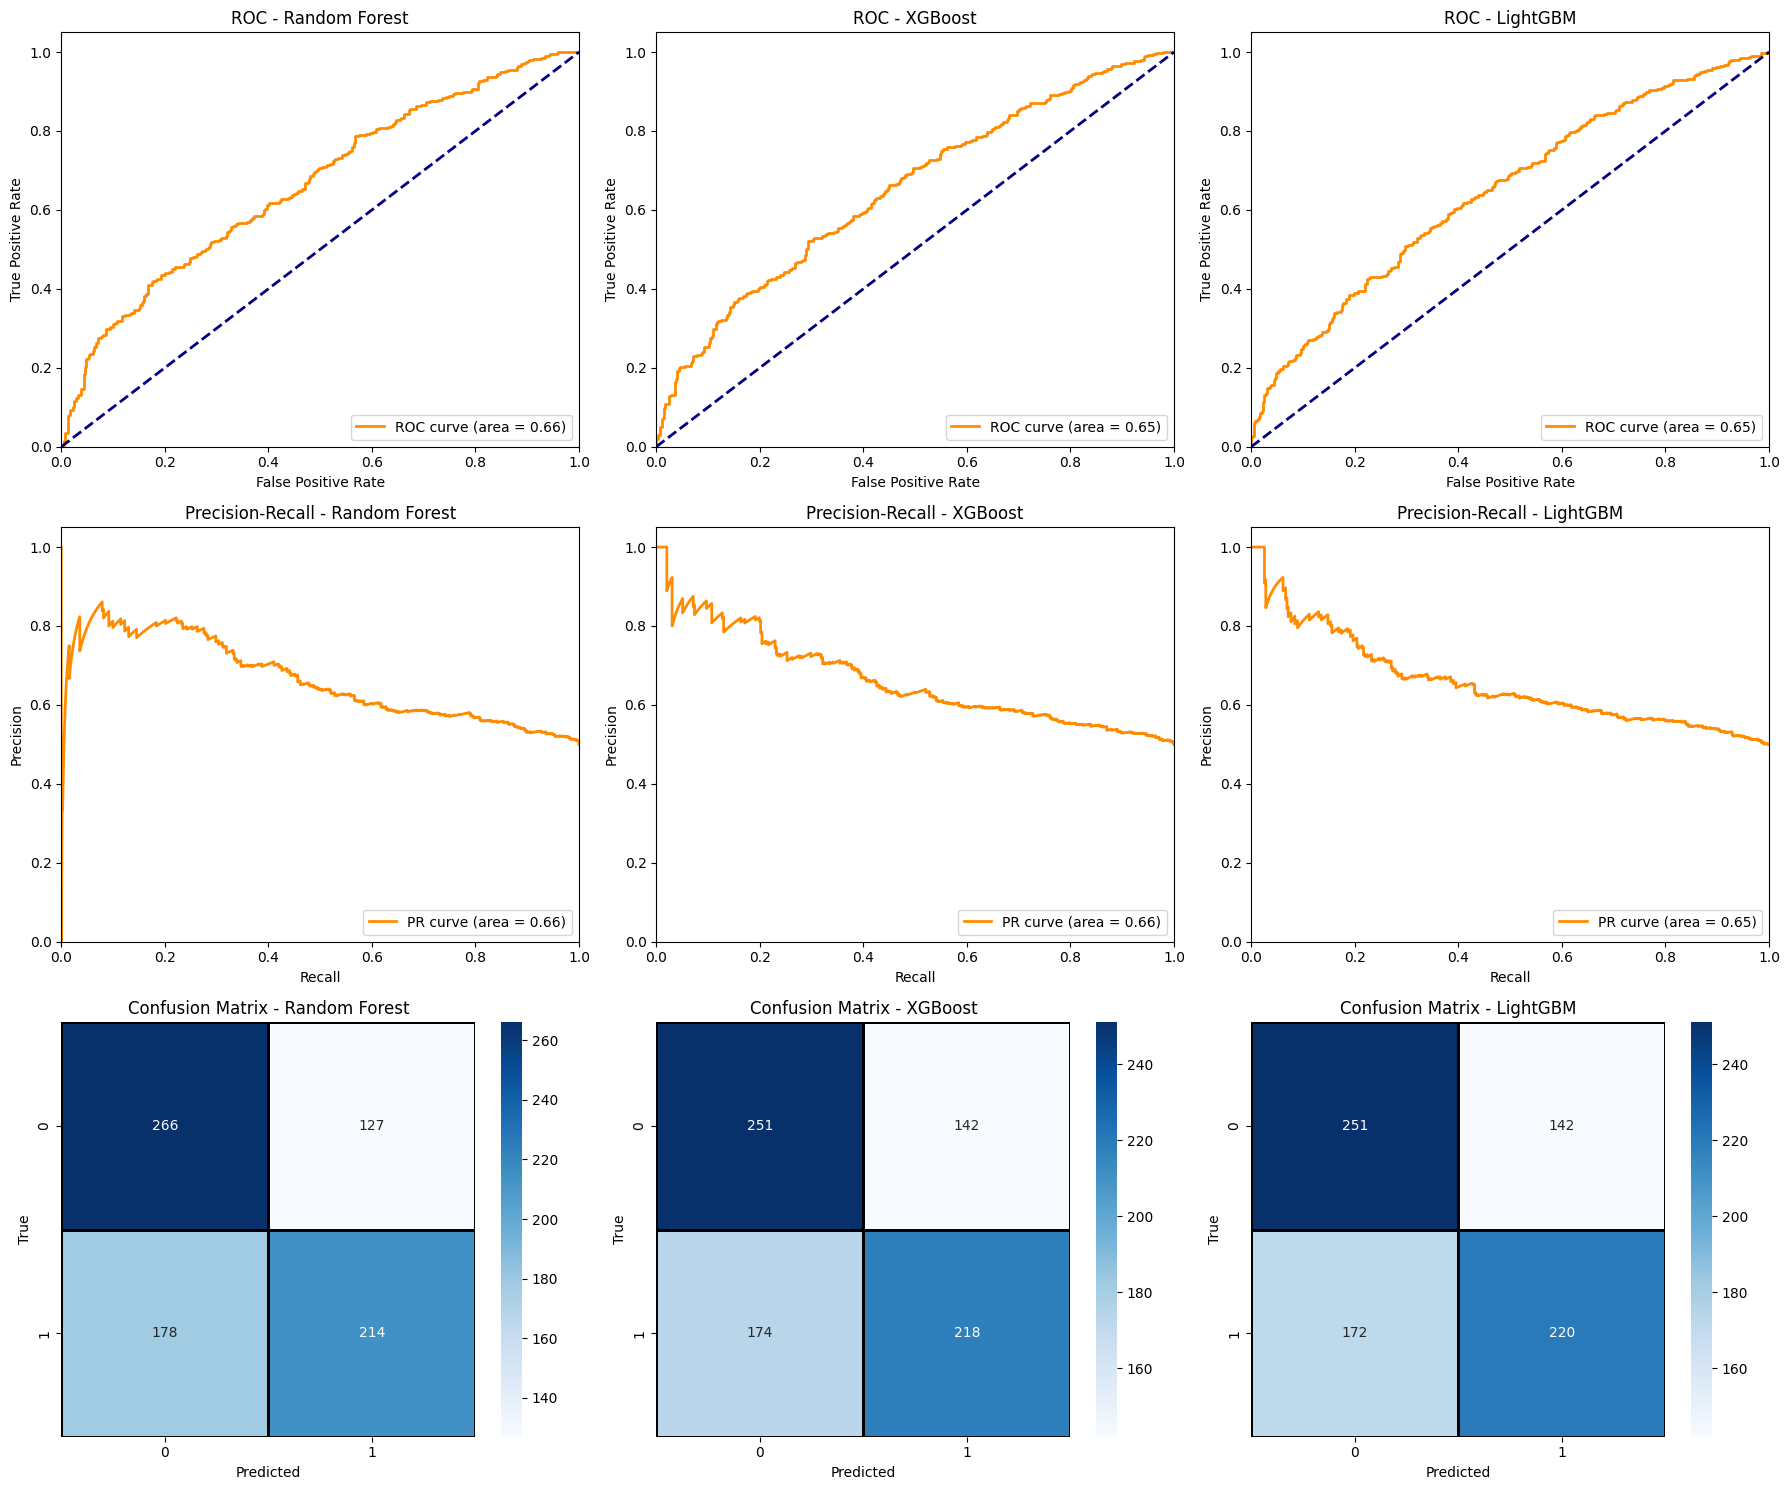

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6114649681528662, 'Precision': 0.6275659824046921, 'Recall': 0.5459183673469388, 'F1 Score': 0.5839017735334242, 'ROC AUC': 0.6642779249104221}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.597452229299363, 'Precision': 0.6055555555555555, 'Recall': 0.5561224489795918, 'F1 Score': 0.5797872340425532, 'ROC AUC': 0.6526133354105}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.6, 'Precision': 0.6077348066298343, 'Recall': 0.5612244897959183, 'F1 Score': 0.583554376657825, 'ROC AUC': 0.6464467466375864}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.6,
 'Precision': 0.6077348066298343,
 'Recall': 0.5612244897959183,
 'F1 Score': 0.583554376657825,
 'ROC AUC': 0.6464467466375864}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6115


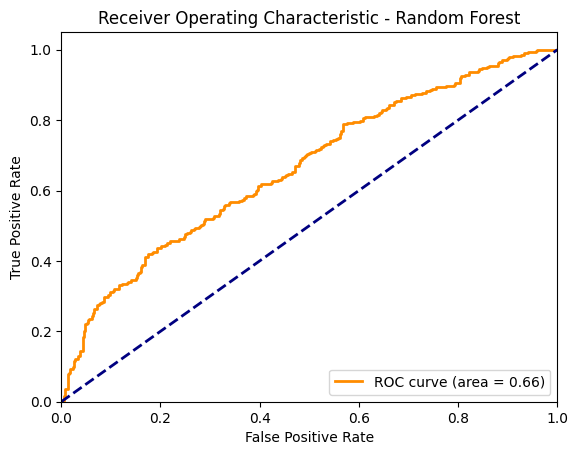

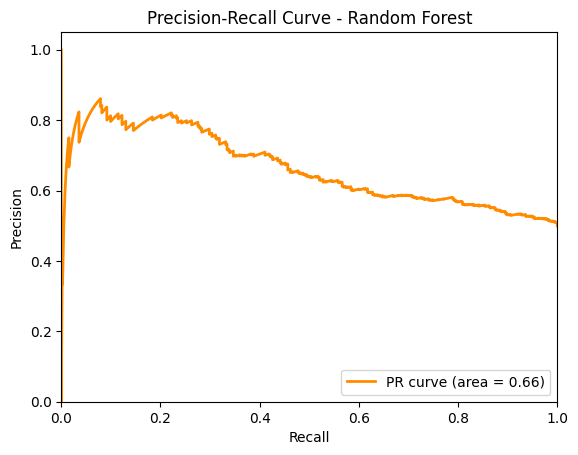

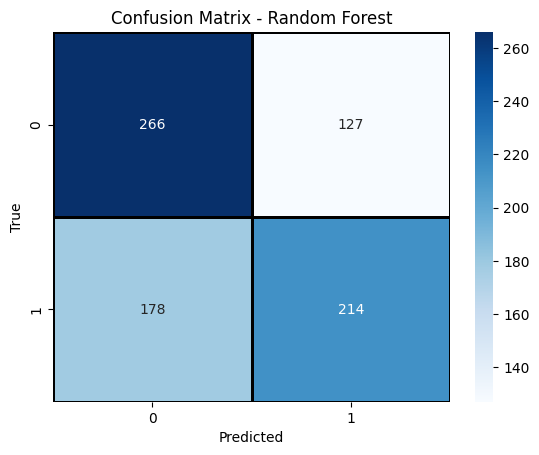

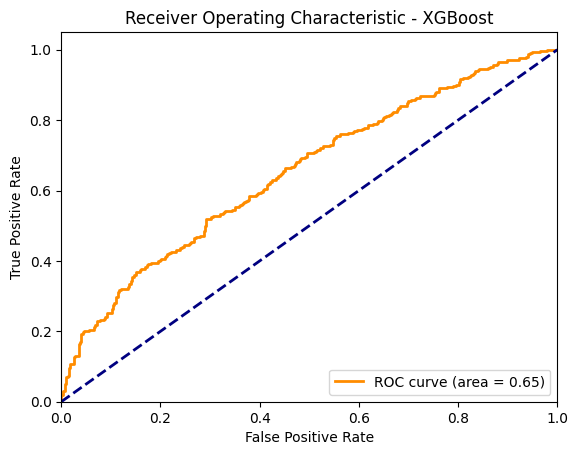

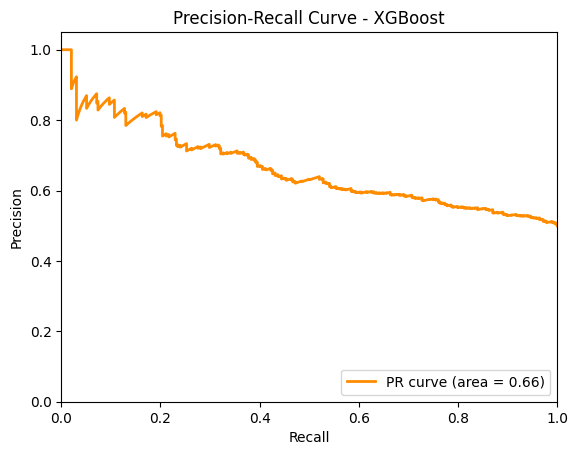

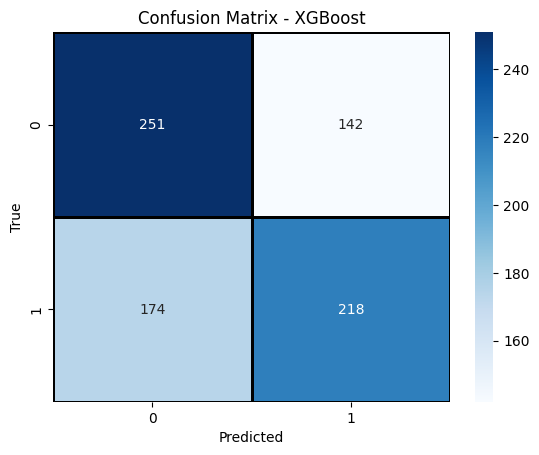

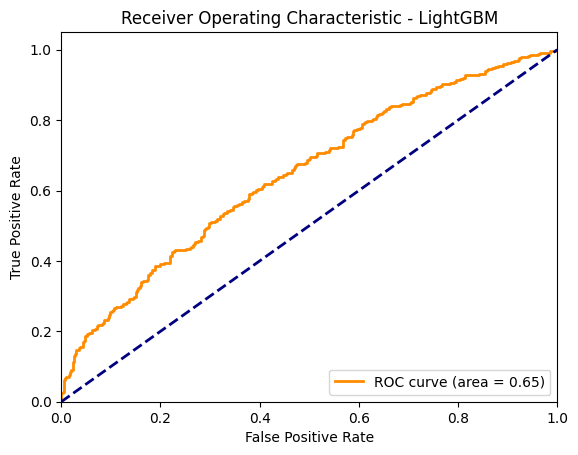

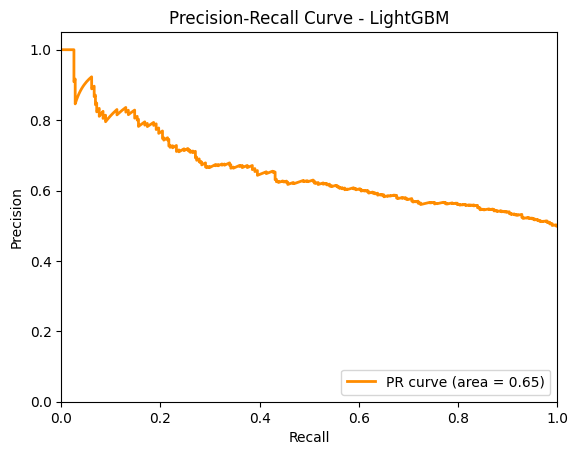

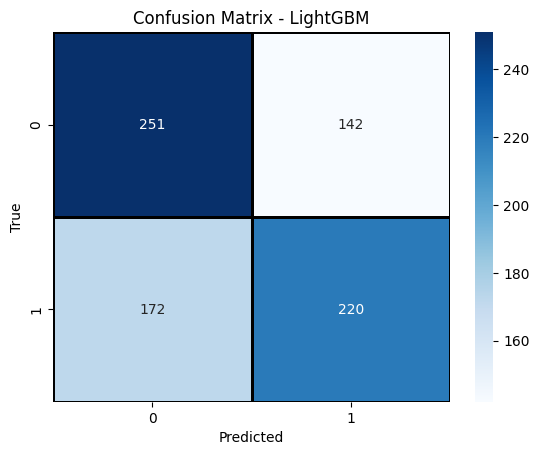

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

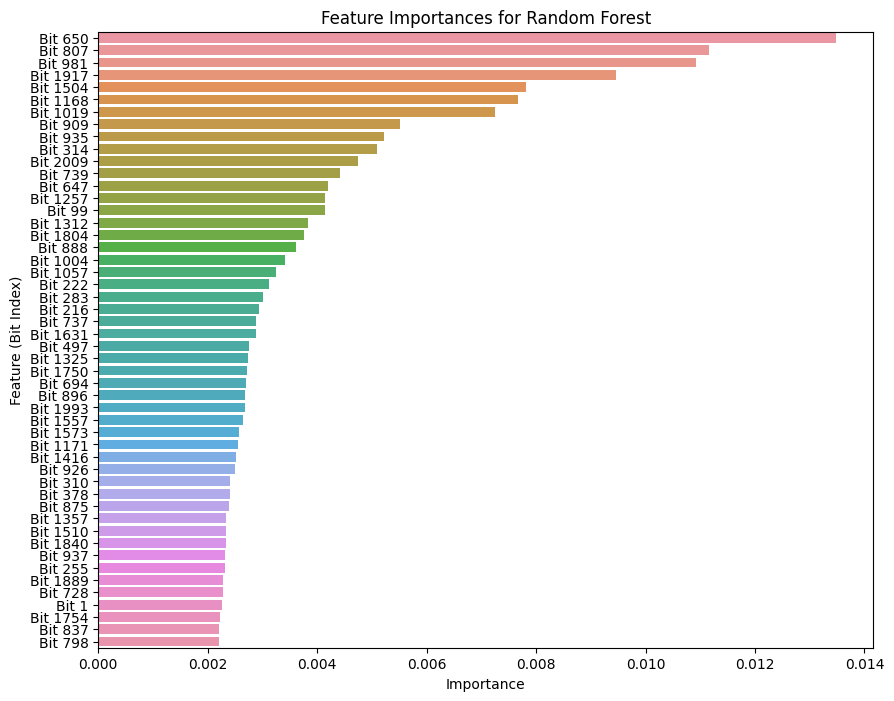

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
